In [1]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random

from data_loader import NuplanDataLoader, NuPlanDataset
from model import RoadMind
from train import train_model
from utils import plot_results

/home/rayan/miniconda3/envs/roadmind_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
data_dir = '../data'
batch_size = 32
num_workers = 4
learning_rate = 0.001
epochs = 1
download_data = False  # Set to False if data is already downloaded

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Initialize data loader and download/extract dataset if needed
loader = NuplanDataLoader(data_dir=data_dir, download=download_data)

# Create data loaders for training, validation and testing
data_paths = loader.get_data_paths()
train_dataset = NuPlanDataset(data_paths['train'])
val_dataset = NuPlanDataset(data_paths['val'])
test_dataset = NuPlanDataset(data_paths['test'], testing=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=num_workers, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                        num_workers=num_workers, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)

# Initialize the model
model = RoadMind()

# print(summary(model, [(1, 3, 200, 300), (1, 1,), (1, 21, 3)],
#         dtypes=[torch.float32, torch.long, torch.float32],
#         device="cpu"))

model = model.to(device)

# Initialize optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

# Train the model
train_losses, val_losses, val_ade, val_fde = train_model(model, train_loader, val_loader, optimizer, scheduler,
                                                         epochs=epochs)
# Create a model directory
model_path = '../model'
os.makedirs(model_path, exist_ok=True)

# Save the trained model
torch.save(model.state_dict(), model_path + 'roadmind_model.pth')
print(f"Model saved to {model_path}/roadmind_model.pth")

# Plot training and validation losses
plot_results(train_losses, val_losses, val_ade, val_fde)
print(f"Loss plot saved to {model_path}/training_metrics.png")


Using device: cuda
Learning rate: [0.001]
Epoch 1/1 , Train Loss: 32.4122, Val Loss: 13.7714, ADE: 4.2987, FDE: 9.3900
Model saved to ../model/roadmind_model.pth
Loss plot saved to ../model/training_metrics.png


In [3]:
def unormalize_image(normalized_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    # Convert lists to tensors if they aren't already
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean, device=normalized_image.device)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std, device=normalized_image.device)
    
    # Reshape mean and std for proper broadcasting
    if normalized_image.dim() == 3:  # (C, H, W)
        mean = mean.view(-1, 1, 1)
        std = std.view(-1, 1, 1)
    elif normalized_image.dim() == 4:  # (B, C, H, W)
        mean = mean.view(1, -1, 1, 1)
        std = std.view(1, -1, 1, 1)
    
    # Reverse the normalization: unnormalized = normalized * std + mean
    unnormalized = normalized_image * std + mean
    
    # Scale to [0, 255] range
    unnormalized = unnormalized.clamp(0, 1) * 255
    
    return unnormalized

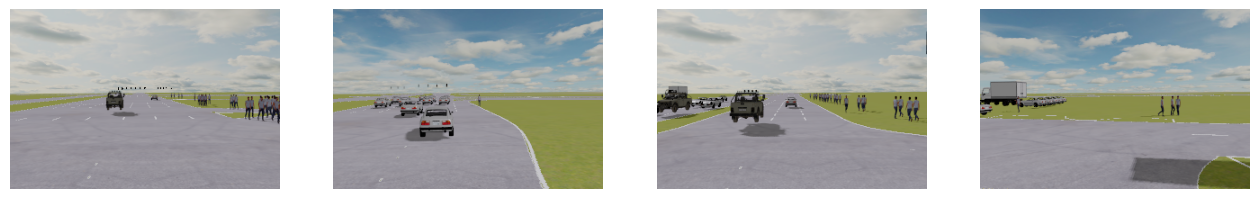

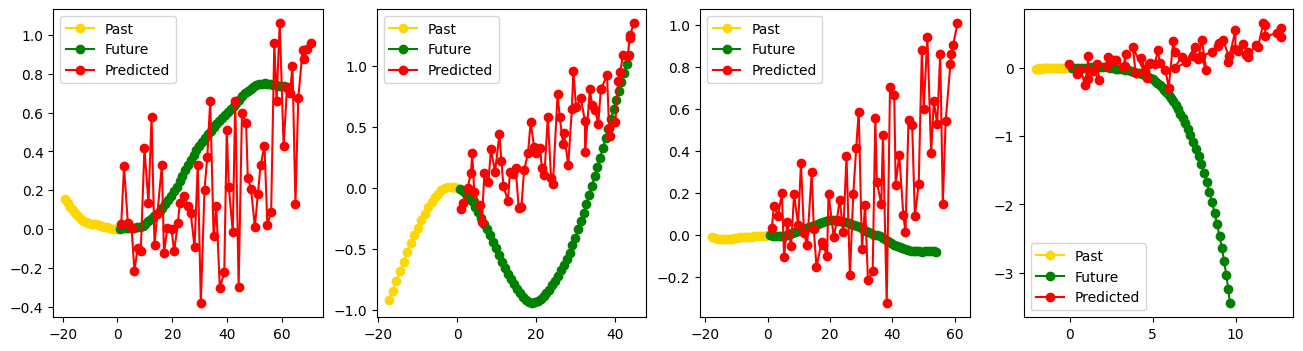

In [6]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
command = val_batch_zero['driving_command'].to(device)
history = val_batch_zero['sdc_history_feature'].to(device)
future = val_batch_zero['sdc_future_feature'].to(device)

model.eval()
with torch.no_grad():
    pred_future = model(camera, command, history)

camera = camera = unormalize_image(camera).cpu().numpy()  # correct unormalization
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()
k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0)/255)
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted")
    axis[i].legend()
    axis[i]

In [5]:
import pandas as pd

model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        driving_command = batch['driving_command'].to(device)
        history = batch['sdc_history_feature'].to(device)
         
        pred_future = model(camera, driving_command, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
submission_dir = '../submission'
os.makedirs(submission_dir, exist_ok=True)
df_xy.to_csv(submission_dir + "/submission_test.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
